# Model for Count Data

Version 2.0 - 06-July-2023

by Luis A. Urso (compilation), USP-EALQ, INSPER, UNIMEP

Credits to: Prof. Luis Paulo Favero, USP-ESALQ


## Introduction

This scrip must be execute from top down, witout let any execution block behind, since there are futher steps those depend on the created variables and functions. 

The dataset used for this exercise is based in a real situation (see the reference)

Reference:
Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence from Diplomatic Parking Tickets.  Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007. https://www.journals.uchicago.edu/doi/abs/10.1086/527495


## 1. REQUIRED PACKAGES AND GLOBAL FUNCTIONS

### 1.1. PACKAGES

In [1]:
## Required Packages Import

import pandas as pd
import numpy as np
from math import exp, factorial

import statsmodels.api as sm # Stats Models Package
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

from scipy import stats
from scipy.stats import norm
from scipy.interpolate import interp1d

import seaborn as sns 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

### 1.2. GLOBAL FUNCTIONS

In [2]:
## FUNCTION: LR TEST (LOG-LIK RATIO TEST) - as known as WILKS TEST
## Access the godness of fit for 2 competing model, specifically one found by 
## maximization against other with constraints. 
## It is expected a p-value < 0.05 to demostrate that the parameters are statistically significantt

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)

## 2. INITIAL EXPLORATORY ANALYSIS

In [3]:
## Load the Dataset CORRUPTION
## Makes basic verifications and Statistics

df_corruption = pd.read_csv('corruption.csv', delimiter=',')
df_corruption

## See Dataset Characteristics 
df_corruption.info()

## See Univariate Statistics 
df_corruption.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [4]:
## Makes a Frequency Table for Dependent Dariable (Y) 'violations'
## Uses the function 'values_counts' from PANDAS, without normalization to generate the percentage counts

## Check Point: Observa that majority (52.3%) of the violations are 0 (Zero) which suggested Excess of Zeros and 
##              a ZIP or ZINB Model maybe more adequate. Later we will verify with detail. 

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = df_corruption['violations'].value_counts(dropna=False, normalize=True)
pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)

,contagem,%
violations,,
0,156,0.523490
1,35,0.117450
2,16,0.053691
3,17,0.057047
4,5,0.016779
5,10,0.033557
6,3,0.010067
7,4,0.013423
8,3,0.010067


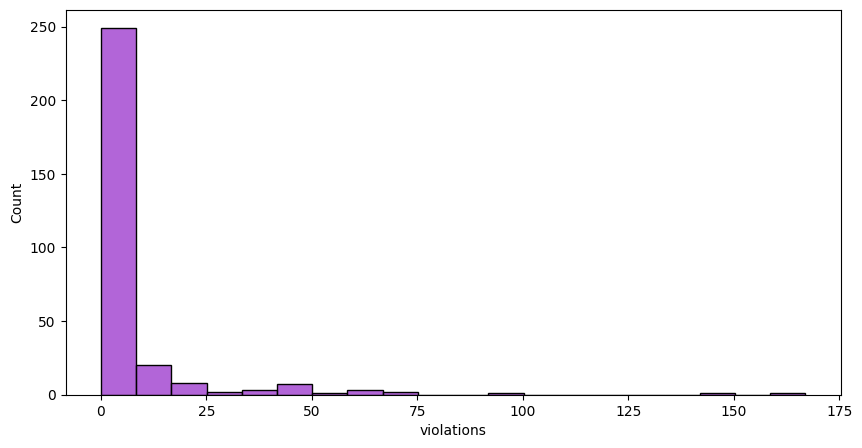

In [5]:
## See the Histogram of Dependent Variable (Y) 'violations'

## Check Point: See that a preliminary view of Y variable in the Histogram, suggests:
##              - Excess of Zeros (Zero-Inflated Models) - concentrate amount of zeros (as verified before)
##              - Overdispersion (Negative Binomial Models) - long tail on right od distribution 

plt.figure(figsize=(10,5))
sns.histplot(data=df_corruption, x="violations", bins=20, color='darkorchid')
plt.show()

In [263]:
## Prelimar diagnostic to observe the equality (or proximity) between MEAN and VARIANCE of the 
## Dependente Variable (Y) 'violations'. 

## Check Point: As in this exercise it is observed a considerable difference (VARIANCE > MEAN),
##              the OVERDISPERSION is present. Therefore this is not the ultimate test, we will verify
##              with more preision ahead in the script


pd.DataFrame({'Mean':[df_corruption.violations.mean()],
              'Variance':[df_corruption.violations.var()]})


,Mean,Variance
0,6.496644,331.617834


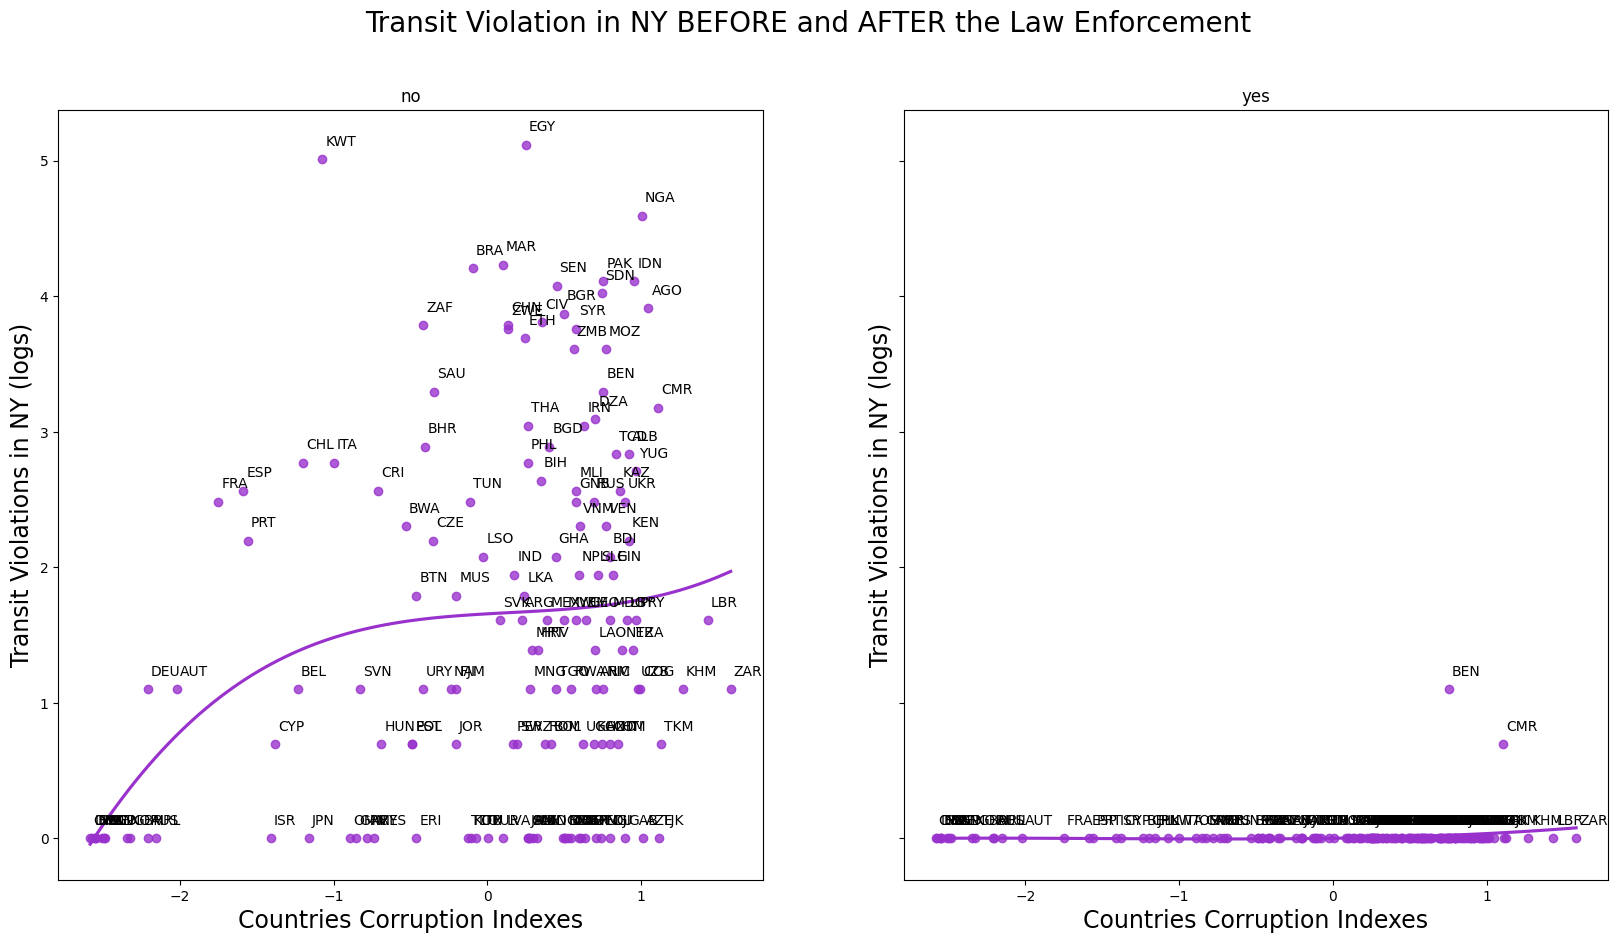

In [264]:
## Check the behavior of variables 'corruption' (X) versus 'violations'(Y), BEFORE the law enforcement 
## (variable 'post'='no') and AFTER the law enforcement (variable 'post'='no') 

fig, axs = plt.subplots(ncols=2, figsize=(20,10), sharey=True)

fig.suptitle('Transit Violation in NY BEFORE and AFTER the Law Enforcement',
             fontsize = 20)

post = ['no','yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations']==np.inf, 'violations'] = 0
    df.loc[df['violations']==-np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',order=3, ax=axs[i],
                ci=False, color='darkorchid')
    axs[i].set_title(v)
    axs[i].set_ylabel("Transit Violations in NY (logs)", fontsize = 17)
    axs[i].set_xlabel("Countries Corruption Indexes", fontsize = 17)
    label_point(df.corruption, df.violations, df.code, axs[i])  

plt.show()

## 3. POISSON MODEL [POISSON]

### 3.1. POISSON DISTRIBUTION CONCEPTS

In [265]:
## POISSON DISTRIBUTION CONCEPTUAL PART (ACADEMIC)

## References: 
## Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement:
## Evidence from Diplomatic Parking Tickets.
## Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
## https://www.journals.uchicago.edu/doi/abs/10.1086/527495

## Creating a POISSON Distribution function based on determined values of LAMBDA and for M data point.

def poisson_lambda(lmbda,m):
    return (exp(-lmbda) * lmbda ** m) / factorial(m)

In [266]:
## Preparing for plotting the different values of LAMBDA

m = np.arange(0,21)

lmbda_1 = []
lmbda_2 = []
lmbda_4 = []

for item in m:
    ## for lambda = 1
    lmbda_1.append(poisson_lambda(1,item))
    ## for lambda = 2
    lmbda_2.append(poisson_lambda(2,item))
    ## for lambda = 4
    lmbda_4.append(poisson_lambda(4,item))

## Temporary Data Frame with lambdas values 

df_lambda = pd.DataFrame({'m':m,
                          'lambda_1':lmbda_1,
                          'lambda_2':lmbda_2,
                          'lambda_4':lmbda_4})
df_lambda

,m,lambda_1,lambda_2,lambda_4
0,0,3.678794e-01,1.353353e-01,1.831564e-02
1,1,3.678794e-01,2.706706e-01,7.326256e-02
2,2,1.839397e-01,2.706706e-01,1.465251e-01
3,3,6.131324e-02,1.804470e-01,1.953668e-01
4,4,1.532831e-02,9.022352e-02,1.953668e-01
5,5,3.065662e-03,3.608941e-02,1.562935e-01
6,6,5.109437e-04,1.202980e-02,1.041956e-01
7,7,7.299195e-05,3.437087e-03,5.954036e-02
8,8,9.123994e-06,8.592716e-04,2.977018e-02
9,9,1.013777e-06,1.909493e-04,1.323119e-02


<function matplotlib.pyplot.show(close=None, block=None)>

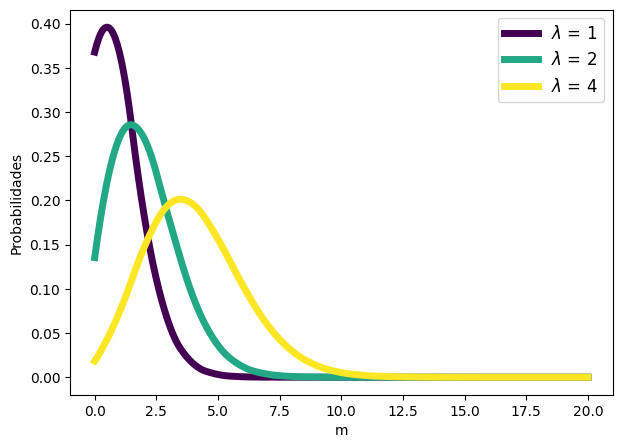

In [267]:
## Plot the graph with diferent values of lambda

from scipy.interpolate import interp1d

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, lambda_1 = smooth_line_plot(df_lambda.m, df_lambda.lambda_1)
x_new, lambda_2 = smooth_line_plot(df_lambda.m, df_lambda.lambda_2)
x_new, lambda_4 = smooth_line_plot(df_lambda.m, df_lambda.lambda_4)

plt.figure(figsize=(7,5))
plt.plot(x_new,lambda_1, linewidth=5, color='#440154FF')
plt.plot(x_new,lambda_2, linewidth=5, color='#22A884FF')
plt.plot(x_new,lambda_4, linewidth=5, color='#FDE725FF')
plt.xlabel('m', fontsize=10)
plt.ylabel('Probabilidades', fontsize=10)
plt.legend([r'$\lambda$ = 1',r'$\lambda$ = 2',r'$\lambda$ = 4'], fontsize=12)
plt.show


### 3.2. POISSON REGRESSION MODEL ESTIMATION

In [268]:
## Makes a POISSON Regression using an open database called CORRUPTION. 

## The argument 'family=sm.families.Poisson()' of function 'smf.glm' defines the 
## estimation model. In our case is Poisson

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

## Verify the model parameters
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Wed, 05 Jul 2023   Deviance:                       3644.0
Time:                        18:03:11   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

In [269]:
## TIP: Another way to se a more complete models is by using the function 'summary_col'

summary_col([modelo_poisson],
            model_names=["MODEL"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })


,MODEL
Intercept,2.2127***
,(0.0311)
post[T.yes],-4.2968***
,(0.1974)
staff,0.0219***
,(0.0012)
corruption,0.3418***
,(0.0275)
N,298
Log-lik,-2071.79


In [270]:
## Check Point: Based on analysis All Prection Variables (X) are statistically different of 0 (zero)
##              considering a Confidence Index [CI] of 5% (ceteris paribus), therefore, can we assume 
##              that the POISSON model is the best to use ?
##              
##              Now we will check the OVERDISPERSION again to confirm and depending on the results, decide
##              if we will have to go for a Negative Binomial Model [NB2]

## OVERDISPESION CAMERON and TRIVEDI Test

## Reference: 
##CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in
##the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

## Steps:
## 1º : Estimate a POISSON Model (done in the steps before);
## 2º : Create a new (Y) variable (Y*) using the fitted values of POISSON Model used before.
## 3º : Estimate an auxiliary OLS Model, with the Y* dependent variable and without a INTERCEPT
##      formula='ystar ~ 0 + lambda_poisson
## 4º : Observe BETA parameter significance

## Adding the lambda POISSON (lambda_poisson) to the original dataframe:
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption

## Creating the Y* to the original dataframe. It will be called 'ystar':
df_corruption['ystar'] = (((df_corruption['violations']
                            -df_corruption['lambda_poisson'])**2)
                          -df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption

## Estimating the auxiliary OLS, without INTERCEPT - see that the intercept is 0:
modelo_auxiliar = smf.ols(formula='ystar ~ 0 + lambda_poisson',
                          data=df_corruption).fit()

## See the parameter os the Auxiliary OLS Model
modelo_auxiliar.summary()

## IMPORTANT
##
## EVALUATING THE RESULTS: If p-value of lambda_poisson parameter is lower than 0.05 (< 0.05)
##                         indicated that the OVERDISPERSION exists, then the POISSON model may not have 
##                         the maximum Log-Lik which suggestes that he estimation of a Negative Binomial [NB2] model
##                         will probably ofer a better maximization of the Log-Lik

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Wed, 05 Jul 2023   Prob (F-statistic):                     0.00625
Time:                        18:04:08   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     2.6525      0.963      2.754      0.006       0.757       4.548
==============================================================================
Omnibus:                      607.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446004.649
Skew:                          13.265   Prob(JB):                         0.00
Kurtosis:                     190.659   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [271]:
## For didatic purposes, lets makes some estimations with POISSON Model.
## What would be the expected amount of TRANSIT VIOLATIONS for a DIPLOMATIC STAFF with 23 people
## consindering BEFORE the LAW ENFORCEMENT for a country with CORRUPTION INDEX = 0.5 ?

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))


0    17.93284
dtype: float64

In [272]:

## Now lets check AFTER the LAW ENFORCEMENT

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

## 4. NEGATIVE BINOMIAL MODEL [NB2]

### 4.1. NEGATIVE BINOMIAL DISTRIBUTION CONCEPTS

In [273]:
## BINOMIAL NEGATIVE [NB2] DISTRIBUTION CONCEPTUAL PART (ACADEMIC)

## Creating a BINOMIAL NEGATIVE Distribution function based on determined values of THETA AND DELTA and for M data point.

#theta: FORM parameter for Poisson-Gama (binomial negative)
#delta: DECAY RATE parameter for Poisson-Gama (binomial negative)

def bneg(theta, delta, m):
    return ((delta ** theta) * (m ** (theta - 1)) * (exp(-m * delta))) / factorial(theta - 1)

In [274]:
## Preparing for plotting the different values of THETA and DELTA

m = np.arange(1,21)

bneg_theta2_delta2 = []
bneg_theta3_delta1 = []
bneg_theta3_delta05 = []

for item in m:
    ## theta=2 and delta=2
    bneg_theta2_delta2.append(bneg(2,2,item))
    ## theta=3 and delta=1
    bneg_theta3_delta1.append(bneg(3,1,item))
    ## theta=3 and delta=0.5
    bneg_theta3_delta05.append(bneg(3,0.5,item))
   
# Creating a data frame variating from 1 to 20 and different values of theta and delta

df_bneg = pd.DataFrame({'m':m,
                        'bneg_theta2_delta2':bneg_theta2_delta2,
                        'bneg_theta3_delta1':bneg_theta3_delta1,
                        'bneg_theta3_delta05':bneg_theta3_delta05})

df_bneg

,m,bneg_theta2_delta2,bneg_theta3_delta1,bneg_theta3_delta05
0,1,5.413411e-01,1.839397e-01,0.037908
1,2,1.465251e-01,2.706706e-01,0.091970
2,3,2.974503e-02,2.240418e-01,0.125511
3,4,5.367402e-03,1.465251e-01,0.135335
4,5,9.079986e-04,8.422434e-02,0.128258
5,6,1.474611e-04,4.461754e-02,0.112021
6,7,2.328280e-05,2.234111e-02,0.092479
7,8,3.601126e-06,1.073480e-02,0.073263
8,9,5.482793e-07,4.998097e-03,0.056239
9,10,8.244614e-08,2.269996e-03,0.042112


<function matplotlib.pyplot.show(close=None, block=None)>

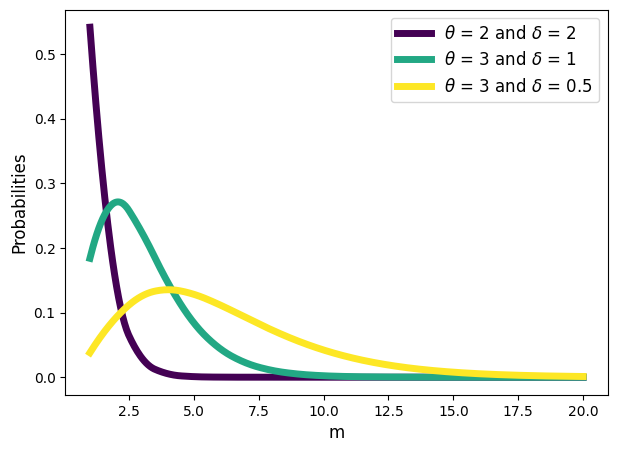

In [275]:
## Plot the graph with diferent values of THETA and DELTA

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, bneg_theta2_delta2 = smooth_line_plot(df_bneg.m,
                                             df_bneg.bneg_theta2_delta2)
x_new, bneg_theta3_delta1 = smooth_line_plot(df_bneg.m,
                                             df_bneg.bneg_theta3_delta1)
x_new, bneg_theta3_delta05 = smooth_line_plot(df_bneg.m,
                                              df_bneg.bneg_theta3_delta05)

plt.figure(figsize=(7,5))
plt.plot(x_new,bneg_theta2_delta2, linewidth=5, color='#440154FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=5, color='#22A884FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=5, color='#FDE725FF')
plt.xlabel('m', fontsize=12)
plt.ylabel('Probabilities', fontsize=12)
plt.legend([r'$\theta$ = 2 and $\delta$ = 2',
            r'$\theta$ = 3 and $\delta$ = 1',
            r'$\theta$ = 3 and $\delta$ = 0.5'],
           fontsize=12)
plt.show

### 4.2. NEGATIVE BINOMIAL [NB2] REGRESSION MODEL ESTIMATION

In [276]:
## Estimating a Binomial Negative [NB2] Model

## See the parameter 'family=sm.families.NegativeBinomial(alpha=2.0963)' of the function 
## 'smf.glm' that defines the estimation of a Binomial Negative Model Type NB2
## with a 'fi' ('alpha' no Python) equal to 2.0963. 'fi' is the inverse of FORM Parameter TETHA
## of Poisson-Gama Distribution (fi=1/theta)

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=2.0963)).fit()

#Parâmetros do modelo
modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Wed, 05 Jul 2023   Deviance:                       239.13
Time:                        18:06:35   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      0.000       1.630       2.264
post[T.yes]    -4.2746      0.266    -16.071      0.000      -4.796      -3.753
staff           0.0400      0.009      4.497      0.000       0.023       0.057
corruption      0.4527      0.115      3.950      0.000       0.228       0.677
===============================================================================
"""

In [277]:
## IMPORTANT : Defining the optimal aplha ('fi') that MAXIMIZES the Log-Lik

n_samples = 10000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)
for i, alpha in enumerate(alphas):
    try:
        model = smf.glm(formula = 'violations ~ staff + post + corruption',
                        data=df_corruption,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf
alpha_otimo = alphas[np.nanargmax(llf)]
alpha_otimo

2.0962096209620964

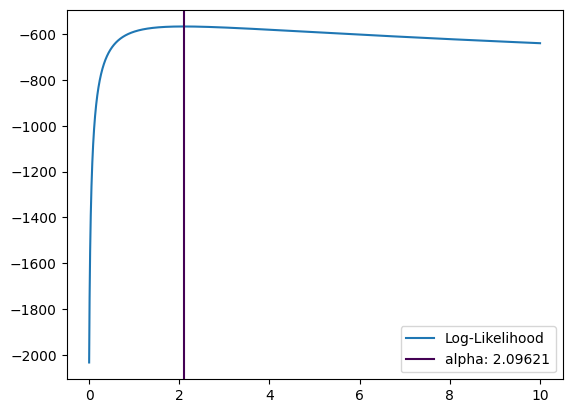

In [278]:
## Plot the ALPHAs Simulation Results 

plt.plot(alphas, llf, label='Log-Likelihood')
plt.axvline(x=alpha_otimo, color='#440154FF',
            label=f'alpha: {alpha_otimo:0.5f}')
plt.legend()

In [279]:
#### I M P O R T A N T ####

## IMPORTANT: Reestimates the Negative Binomial Model with the optimal alpha ('alpha_otimo')

modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=alpha_otimo)).fit()

## See the Model Parameters 
modelo_bneg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Wed, 05 Jul 2023   Deviance:                       239.14
Time:                        18:07:26   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      0.000       1.630       2.264
post[T.yes]    -4.2746      0.266    -16.071      0.000      -4.796      -3.753
staff           0.0400      0.009      4.497      0.000       0.023       0.057
corruption      0.4527      0.115      3.950      0.000       0.228       0.677
===============================================================================
"""

In [280]:
## Compares the Models POISSON x NEGATIVE BINOMIAL (NB2)

## Check Point: See that the Log-Lik of the NB2 model is better (higher) than the POISSON MODEL

summary_col([modelo_poisson, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,Poisson,BNeg
Intercept,2.2127***,1.9469***
,(0.0311),(0.1616)
post[T.yes],-4.2968***,-4.2746***
,(0.1974),(0.2660)
staff,0.0219***,0.0400***
,(0.0012),(0.0089)
corruption,0.3418***,0.4527***
,(0.0275),(0.1146)
N,298,298
Log-lik,-2071.79,-567.40


In [281]:
## Log-Lik Ratio Test - expectec a p-value < 0.05 
## Comparing Significance of Poisson x BNEG

lrtest([modelo_poisson, modelo_bneg])

(3008.79, 0.0)

Text(0.5, 0, 'Log-Likehood')

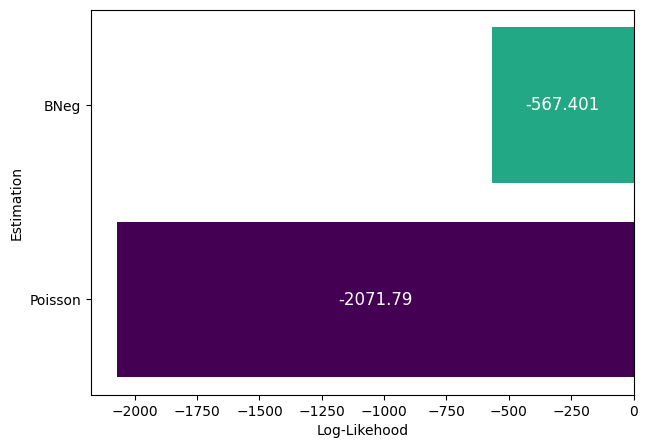

In [282]:
## Graphic comparing the POISSON and NB2 Log-Liks
## See that NB2 has a better performance (higher Log-Lik)

## Define a Datafram with the Log-Liks for each model
df_llf = pd.DataFrame({'modelo':['Poisson','BNeg'],
                      'loglik':[modelo_poisson.llf, modelo_bneg.llf]})
df_llf

## Plot
fig, ax = plt.subplots(figsize=(7,5))

c = ['#440154FF', '#22A884FF']

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=12)
ax.set_ylabel("Estimation", fontsize=10)
ax.set_xlabel("Log-Likehood", fontsize=10)

In [292]:
## Comparing Prevision NB2 x POISSON

## What would be the expected amount of TRANSIT VIOLATIONS for a DIPLOMATIC STAFF with 23 people
## consindering BEFORE the LAW ENFORCEMENT for a country with CORRUPTION INDEX = 0.5 ?


## Model Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))



0    17.93284
dtype: float64

In [284]:
## Model NB2:
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    22.05725
dtype: float64

In [285]:

## Now lets check AFTER the LAW ENFORCEMENT

## Model Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [286]:
## Model NB2
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.306974
dtype: float64

In [293]:
## Addint POISSON and NB2 Fitted Values to the Original Dataset 

df_corruption['fitted_poisson'] = modelo_poisson.fittedvalues
df_corruption['fitted_bneg'] = modelo_bneg.fittedvalues

df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar,fitted_poisson,fitted_bneg
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208,15.919915,16.138591
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289,0.216711,0.224603
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843,13.371720,11.987629
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023,0.182023,0.166834
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915,7.477915,5.551769
...,...,...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691,0.243691,0.253810
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347,13.486751,12.955687
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589,0.183589,0.180306
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120,12.994217,13.033499


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 300x300 with 0 Axes>

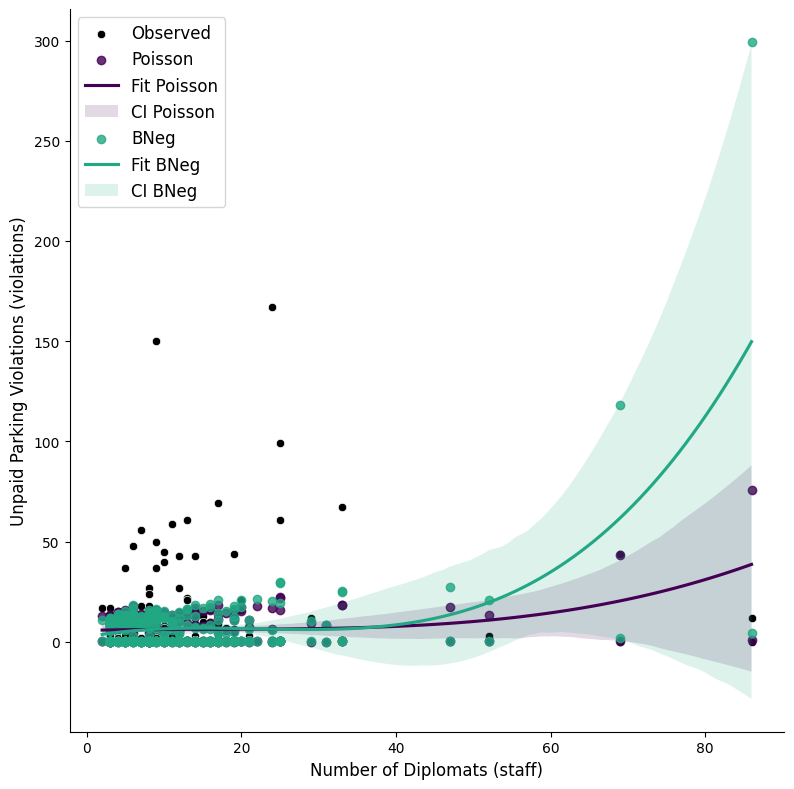

In [294]:
## Plot a comparission of POISSON x NB2 by STAFF (X) x VIOLATIONS (Y)

plt.figure(figsize=(3,3))
sns.relplot(data=df_corruption, x='staff', y='violations', color='black', height=8)
sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3,
            color='#440154FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3,
            color='#22A884FF')
plt.xlabel('Number of Diplomats (staff)', fontsize=12)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=12)
plt.legend(['Observed', 'Poisson', 'Fit Poisson', 'CI Poisson',
            'BNeg', 'Fit BNeg', 'CI BNeg'],
           fontsize=12)
plt.show

## 5. ZERO-INFLATED POISSON MODEL [ZIP]

### 5.1. ZERO-INFLATED POISSON DISTRIBUTION CONCEPTS

In [295]:
## ZERO-INFLATED POISSON DISTRIBUTION CONCEPTS 

## Reference: 
## LAMBERT, D. Zero-inflated Poisson regression, with an application to defects
## in manufacturing. Technometrics, v. 34, n. 1, p. 1-14, 1992.

## Creates a function for ZIP , with lambda=1 and plogit=0,7
def zip_lambda1_plogit07(m):
    lmbda = 1
    plogit = 0.7
    
    if m == 0:
        return (plogit) + ((1 - plogit) * exp(-lmbda))
    else:
        return (1 - plogit) * ((exp(-lmbda) * lmbda ** m) / factorial(m))

In [296]:
## Prepare the data for plotting

m = np.arange(0,21)

zip_lambda1_plogit07 = [zip_lambda1_plogit07(i) for i in m]

## Creates a dataframe with 'm' from 0 to 20

df_zip = pd.DataFrame({'m':m,
                       'zip_lambda1_plogit07':zip_lambda1_plogit07})
df_zip

,m,zip_lambda1_plogit07
0,0,8.103638e-01
1,1,1.103638e-01
2,2,5.518192e-02
3,3,1.839397e-02
4,4,4.598493e-03
5,5,9.196986e-04
6,6,1.532831e-04
7,7,2.189759e-05
8,8,2.737198e-06
9,9,3.041331e-07


<function matplotlib.pyplot.show(close=None, block=None)>

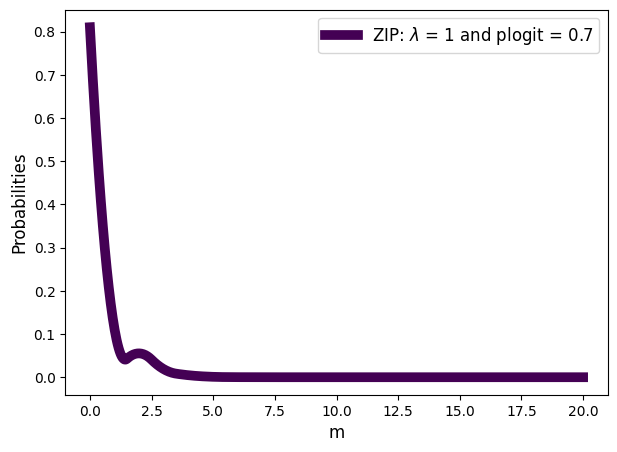

In [297]:
## Plotting ZIP Distribution 

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zip_lambda1_plogit07 = smooth_line_plot(df_zip.m,
                                               df_zip.zip_lambda1_plogit07)

plt.figure(figsize=(7,5))
plt.plot(x_new,zip_lambda1_plogit07, linewidth=7, color="#440154FF")
plt.xlabel('m', fontsize=12)
plt.ylabel('Probabilities', fontsize=12)
plt.legend([r'ZIP: $\lambda$ = 1 and plogit = 0.7'],
           fontsize=12)
plt.show


### 5.2. ZERO-INFLATED POISSON MODEL ESTIMATION

In [298]:
## Estimating ZIP Model

## Defining the dependent variable (Y) that is 'violations' (dataset 'df_corruption')
y = df_corruption.violations

## Defining the prediction variables (Xs)
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

## Defining the prediction variables that will be part of LOGIT (inflated) componente. 
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

## For this model it is required to make the categorical variables a DUMMY. 
## Dummization for 'post' variable.
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)

## Impostant - Need to convert to float, else an it will throw an error in the fit function.
X1 = X1.astype(float) 

## Makes the ZIP Model using the ZeroInflatedPoisson from package 'Statsmodels'
## Argument: 'exog_infl' are the variables to consider in the LOGIT (Inflated)

modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                     inflation='logit').fit()

## See the Model Parameters
modelo_zip.summary()

Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              violations   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Wed, 05 Jul 2023   Pseudo R-squ.:                  0.1975
Time:                         18:11:08   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const         -1.6116      0.240     -6.714      0.000      -2.082      -1.141
inflate_corruption    -0.9523      0.195     -4.875      0.000      -1.335      -0.569
const                  2.4889      0.032     78.990      0.000       2.427       2.551
staff                  0.0200      0.001     16.154      0.000       0.018       0.022
corruption             0.0937      0.030      3.127      0.002       0.035       0.152
post_yes              -4.2879      0.201    -21.291      0.000      -4.683      -3.893
======================================================================================
"""

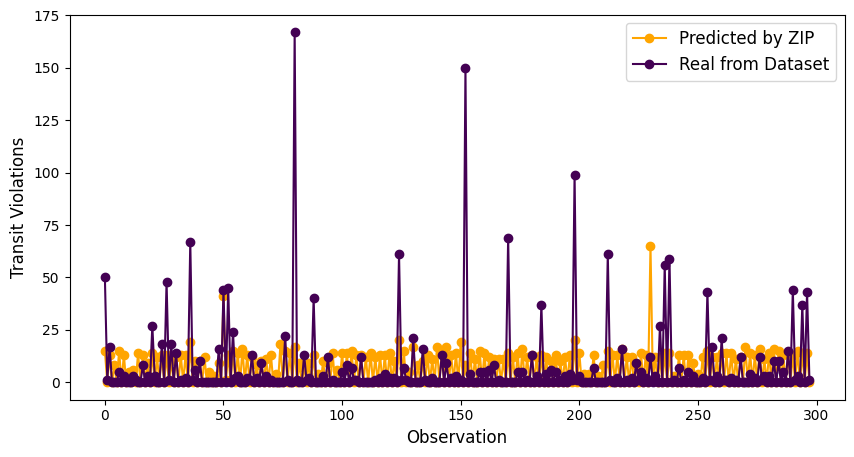

In [299]:
## Plot a Graph to Compare Predicted Transit Violations x Real Transit Violations
## Using the fitted ZIP Model 

## Observations: See that naturaly the ZIP Model removes the outliers

zip_predictions = modelo_zip.predict(X1, exog_infl=X2)
predicted_counts = np.round(zip_predictions)
actual_counts = df_corruption['violations']

plt.figure(figsize=(10,5))
plt.plot(df_corruption.index, predicted_counts, 'go-',
         color='orange')
plt.plot(df_corruption.index, actual_counts, 'go-',
         color='#440154FF')
plt.xlabel('Observation', fontsize=12)
plt.ylabel('Transit Violations', fontsize=12)
plt.legend(['Predicted by ZIP', 'Real from Dataset'],
           fontsize=12)
plt.show()

In [300]:
## Comparing the models performance POISSON x ZIP
## POISSON is always compared against ZIP

## Check Point: See that the Log-Lik for ZIP Model is better (higher than) the POISSON

summary_col([modelo_poisson, modelo_zip], 
            model_names=["Poisson","ZIP"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,Poisson,ZIP
Intercept,2.2127***,
,(0.0311),
const,,2.4889***
,,(0.0315)
corruption,0.3418***,0.0937***
,(0.0275),(0.0300)
inflate_const,,-1.6116***
,,(0.2401)
inflate_corruption,,-0.9523***
,,(0.1954)


In [301]:
## LR - likelihood ratio test to compared the models Log-Lik
## Comopare ZIP x POISSON Log-Liks. Expected p-value < 0.05 to confirm it is a Zero Inflated

lrtest([modelo_poisson, modelo_zip])

(580.97, 0.0)

Text(0.5, 0, 'Log-Likehood')

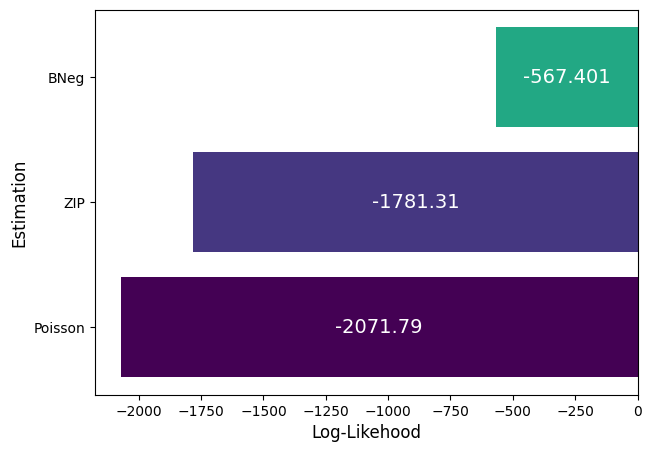

In [302]:
## Plot a Graph to compare the Log-Liks Poisson, BNeg e ZIP
## See that the BNEG model still have better performant (higher Log-Lik) and the reason is
## associated to the fact that we have a distribution with EXCESS OF ZEROS, which
## sugested we may try a Zero-Inflated Negative Binomial Model (ZINB) that certainly 
## will offer a better Log-Lik.

##Defining a dataframe with the respective LL

df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf]})

## Plotting 
fig, ax = plt.subplots(figsize=(7,5))

c = ["#440154FF", "#453781FF", "#22A884FF"]

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=14)
ax.set_ylabel("Estimation", fontsize=12)
ax.set_xlabel("Log-Likehood", fontsize=12)

In [303]:
## Comparing Prevision POISSON, NB2, ZIP

## What would be the expected amount of TRANSIT VIOLATIONS for a DIPLOMATIC STAFF with 23 people
## consindering BEFORE the LAW ENFORCEMENT for a country with CORRUPTION INDEX = 0.5 ?


## Model Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

In [304]:
## Model NB2:
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['no'],
                                  'corruption':[0.5]}))

0    22.05725
dtype: float64

In [305]:
## Model ZIP
## IMPORTANT - Must keep the same parameter order used in the FIT function
modelo_zip.params

modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[0]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    17.802404
dtype: float64

In [306]:
## Now lets check AFTER the LAW ENFORCEMENT

## Model Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [307]:
## Model NB2:
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['yes'],
                                  'corruption':[0.5]}))

0    0.306974
dtype: float64

In [308]:
## Modelo ZIP:
modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[1]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))


0    0.24449
dtype: float64

## 6. ZERO-INFLATED NEGATIVE BINOMIAL [ZINB]

### 6.1. ZERO-INFLATED NEGATIVE BINOMIAL DISTRIBUTION CONCEPTS

In [309]:
## ZINB DISTRIBUTION CONCEPT

## Function for ZINB Distributuion, withtheta = 2,
## delta = 2, plogit = 0.7 and lambda_bneg = 2

def zinb_theta2_delta2_plogit07_lambda2(m):
    lambda_bneg = 1
    plogit = 0.7
    theta = 2
    delta = 2
    if m == 0:
        return (plogit) + ((1 - plogit) *
                           (((1) / (1 + 1/theta * lambda_bneg)) ** theta))
    else:
        return (1 - plogit) * ((delta ** theta) * (m ** (theta - 1)) *
                               (exp(-m * delta))) / factorial(theta - 1)

In [310]:
## Prepare the data to plot ZINB Distribution

m = np.arange(0,21)

zinb_theta2_delta2_plogit07_lambda2 = [zinb_theta2_delta2_plogit07_lambda2(i)
                                       for i in m]

#Criando um dataframe com m variando de 0 a 20

df_zinb = pd.DataFrame({'m':m,
                       'zinb_theta2_delta2_plogit07_lambda2':zinb_theta2_delta2_plogit07_lambda2})
df_zinb


,m,zinb_theta2_delta2_plogit07_lambda2
0,0,8.333333e-01
1,1,1.624023e-01
2,2,4.395753e-02
3,3,8.923508e-03
4,4,1.610221e-03
5,5,2.723996e-04
6,6,4.423833e-05
7,7,6.984841e-06
8,8,1.080338e-06
9,9,1.644838e-07


<function matplotlib.pyplot.show(close=None, block=None)>

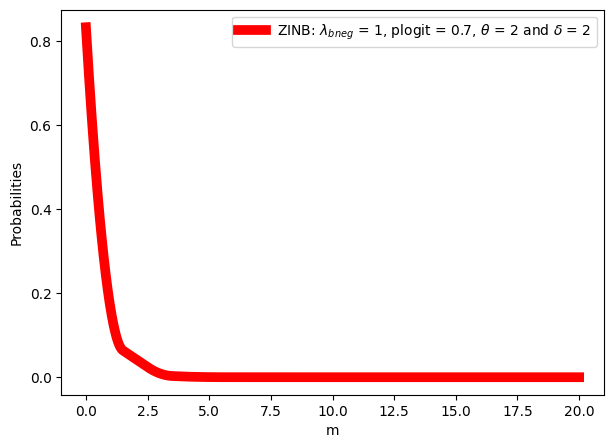

In [311]:
## Plot the ZINB Distribution

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zinb_theta2_delta2_plogit07_lambda2 = smooth_line_plot(df_zinb.m,
                                                              df_zinb.zinb_theta2_delta2_plogit07_lambda2)

plt.figure(figsize=(7,5))
plt.plot(x_new,zinb_theta2_delta2_plogit07_lambda2, linewidth=7, color="red")
plt.xlabel('m', fontsize=10)
plt.ylabel('Probabilities', fontsize=10)
plt.legend([r'ZINB: $\lambda$$_{bneg}$ = 1, plogit = 0.7, $\theta$ = 2 and $\delta$ = 2'],
           fontsize=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

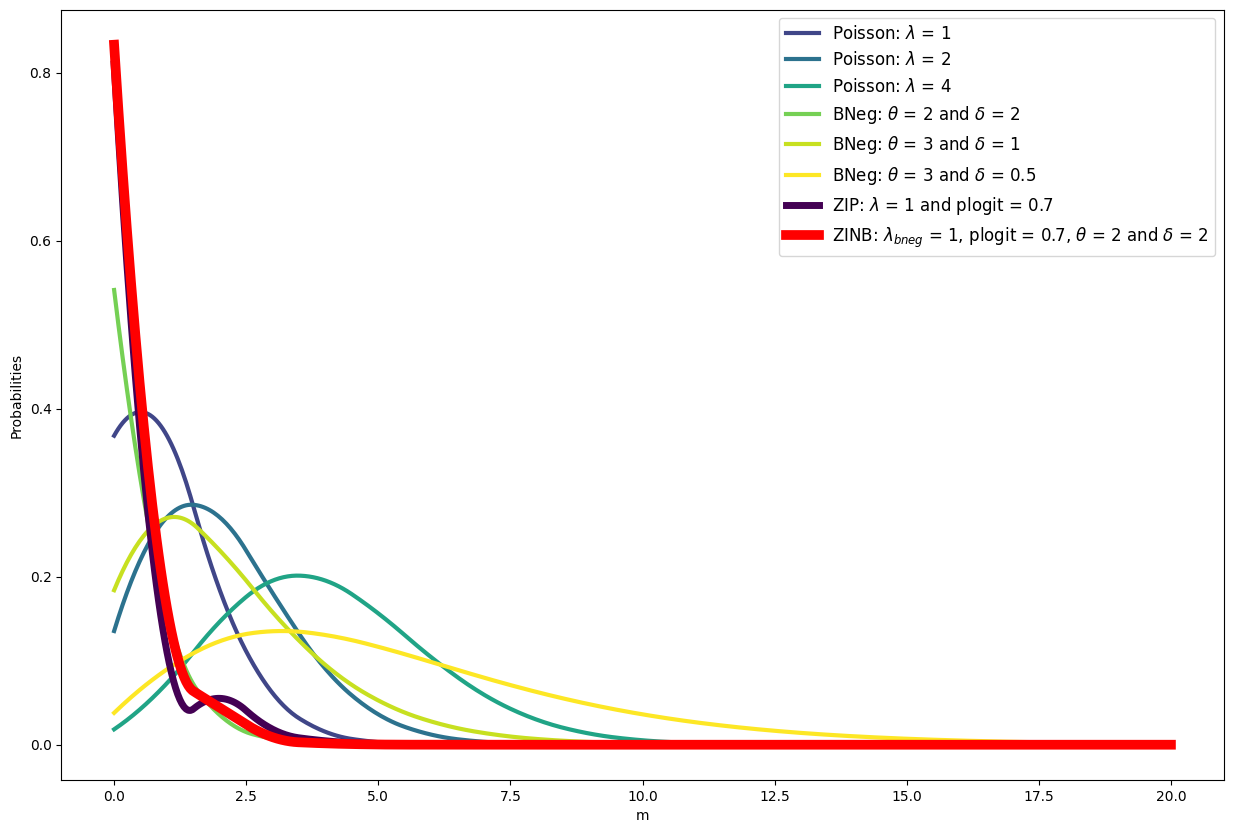

In [312]:
#### NICE TO SEE ####

### PLOT A DISTRIBUTION COMPARISION BETWEEN: POISSON, BNEG, ZIP AND ZINB

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, zinb_theta2_delta2_plogit07_lambda2 = smooth_line_plot(df_zinb.m,
                                                              df_zinb.zinb_theta2_delta2_plogit07_lambda2)

plt.figure(figsize=(15,10))
plt.plot(x_new,lambda_1, linewidth=3, color='#404688FF')
plt.plot(x_new,lambda_2, linewidth=3, color='#2C728EFF')
plt.plot(x_new,lambda_4, linewidth=3, color='#20A486FF')
plt.plot(x_new,bneg_theta2_delta2, linewidth=3, color='#75D054FF')
plt.plot(x_new,bneg_theta3_delta1, linewidth=3, color='#C7E020FF')
plt.plot(x_new,bneg_theta3_delta05, linewidth=3, color='#FDE725FF')
plt.plot(x_new,zip_lambda1_plogit07, linewidth=5, color="#440154FF")
plt.plot(x_new,zinb_theta2_delta2_plogit07_lambda2, linewidth=7, color="red")
plt.xlabel('m', fontsize=10)
plt.ylabel('Probabilities', fontsize=10)
plt.legend([r'Poisson: $\lambda$ = 1',
            r'Poisson: $\lambda$ = 2',
            r'Poisson: $\lambda$ = 4',
            r'BNeg: $\theta$ = 2 and $\delta$ = 2',
            r'BNeg: $\theta$ = 3 and $\delta$ = 1',
            r'BNeg: $\theta$ = 3 and $\delta$ = 0.5',
            r'ZIP: $\lambda$ = 1 and plogit = 0.7',
            r'ZINB: $\lambda$$_{bneg}$ = 1, plogit = 0.7, $\theta$ = 2 and $\delta$ = 2'],
           fontsize=12)
plt.show

### 6.2. ZERO-INFLATED NEGATIVE BINOMIAL MODEL ESTIMATION

In [313]:
## Estimating ZINB Model

## Defining the dependent variable (Y) that is 'violations' (dataset 'df_corruption')
y = df_corruption.violations

## Defining the prediction variables (Xs)
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

## Defining the prediction variables that will be part of LOGIT (inflated) componente. 
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

## For this model it is required to make the categorical variables a DUMMY. 
## Dummization for 'post' variable.
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)

## Impostant - Need to convert to float, else an it will throw an error in the fit function.
X1 = X1.astype(float) 

## Makes the ZIP Model using the ZeroInflatedPoisson from package 'Statsmodels'
## Argument: 'exog_infl' are the variables to consider in the LOGIT (Inflated)

modelo_zinb = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2,
                                     inflation='logit').fit()

## See the Model Parameters
modelo_zinb.summary()

         Current function value: 1.870015
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                        violations   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      294
Method:                                      MLE   Df Model:                            3
Date:                           Wed, 05 Jul 2023   Pseudo R-squ.:                  0.1700
Time:                                   18:12:04   Log-Likelihood:                -557.26
converged:                                 False   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 3.353e-49
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const        -17.9857      9.287     -1.937      0.053     -36.187       0.216
inflate_corruption    -8.1104      4.037     -2.009      0.045     -16.023      -0.197
const                  2.0324      0.203      9.988      0.000       1.634       2.431
staff                  0.0411      0.013      3.078      0.002       0.015       0.067
corruption             0.1815      0.147      1.237      0.216      -0.106       0.469
post_yes              -4.2638      0.261    -16.328      0.000      -4.776      -3.752
alpha                  1.8560      0.218      8.518      0.000       1.429       2.283
======================================================================================
"""

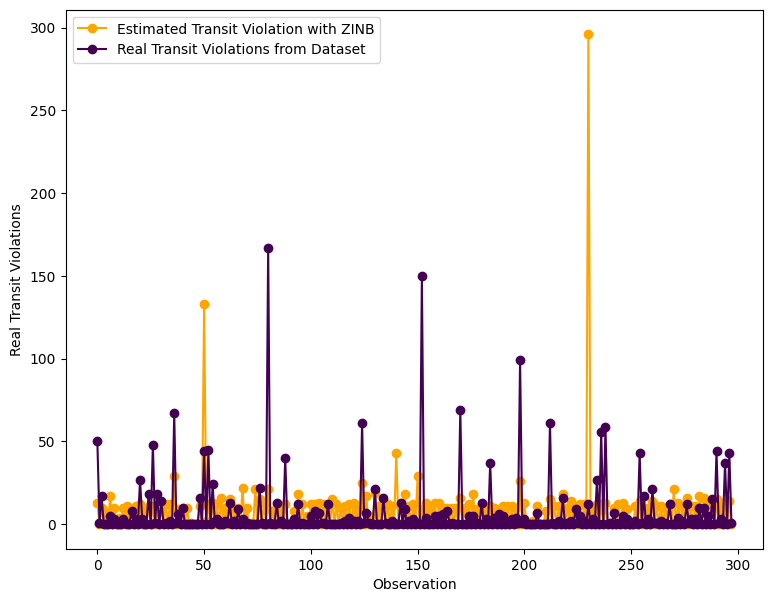

In [314]:
## Plot a graph to compare the ZINB Estimated Transit Violations x the Real
## Transit Violation in the Original Dataset

## Checkpoint: See that the ZINB has a higher Log-Lik, so it will be the best model.

zinb_predictions = modelo_zinb.predict(X1, exog_infl=X2)
predicted_counts = np.round(zinb_predictions)
actual_counts = df_corruption['violations']

plt.figure(figsize=(9,7))
plt.plot(df_corruption.index, predicted_counts, 'go-',
         color='orange')
plt.plot(df_corruption.index, actual_counts, 'go-',
         color='#440154FF')
plt.xlabel('Observation', fontsize=10)
plt.ylabel('Real Transit Violations', fontsize=10)
plt.legend(['Estimated Transit Violation with ZINB', 'Real Transit Violations from Dataset'],
           fontsize=10)
plt.show()

In [315]:
## Comparing Models BNeg e ZINB
## BNEG is always compared against ZINB

summary_col([modelo_bneg, modelo_zinb], 
            model_names=["BNeg","ZINB"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,BNeg,ZINB
Intercept,1.9469***,
,(0.1616),
alpha,,1.8560***
,,(0.2179)
const,,2.0324***
,,(0.2035)
corruption,0.4527***,0.1815
,(0.1146),(0.1466)
inflate_const,,-17.9857*
,,(9.2867)


In [316]:
## Verify the Lok-Lik Ratio (BNEG x ZINB)
## Expetected a p-value < 0.05 - Confirmation it is a Zero Inflated

lrtest([modelo_bneg, modelo_zinb])

(20.27, 0.0)

Text(0.5, 0, 'Log-Likehood')

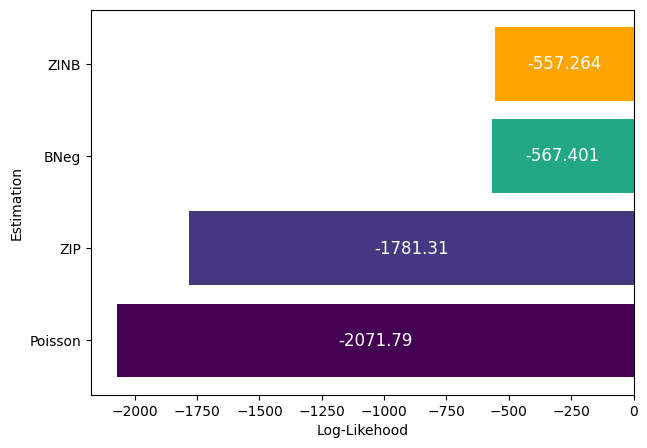

In [317]:
## Graph comparing All Models Lok-liks

## CHECK POINT : See that the ZINB Model has the higher Log-lik (close to 0), this indicates that this 
##               model offers the best performance and the BETAs + additional parameters will offer
##               good values for exploratory analysis and prediction. 

## Define a dataframe with all LLs
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf,
                                modelo_zinb.llf]})
df_llf

## Plot the Lok-liks for each Model

fig, ax = plt.subplots(figsize=(7,5))

c = ["#440154FF", "#453781FF", "#22A884FF", "orange"]

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=12)
ax.set_ylabel("Estimation", fontsize=10)
ax.set_xlabel("Log-Likehood", fontsize=10)

In [318]:
## Comparing Previsions POISSON, NB2, ZIP, ZINB

## What would be the expected amount of TRANSIT VIOLATIONS for a DIPLOMATIC STAFF with 23 people
## consindering BEFORE the LAW ENFORCEMENT for a country with CORRUPTION INDEX = 0.5 ?


## Model Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

In [319]:
## Model NB2
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['no'],
                                  'corruption':[0.5]}))

0    22.05725
dtype: float64

In [320]:
## Model ZIP
## Obs: Keep the same parameter order used in the ZIP Model FIT
modelo_zip.params

modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[0]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    17.802404
dtype: float64

In [321]:
## Modelo ZINB:
## Obs: Keep the same parameter order used in the ZINB Model FIT
modelo_zinb.params

modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[0]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    21.495939
dtype: float64

In [230]:
## Now lets check AFTER the LAW ENFORCEMENT

## Model Poisson
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [322]:
## Model NB2:
modelo_bneg.predict(pd.DataFrame({'staff':[23],
                                  'post':['yes'],
                                  'corruption':[0.5]}))

0    0.306974
dtype: float64

In [323]:
## Model ZIP:
modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[1]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    0.24449
dtype: float64

In [324]:
## Model ZINB
modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[1]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    0.302422
dtype: float64

In [325]:
## Add ZIP and ZINB Fitted Values to the Original Dataset

df_corruption['fitted_zip'] = modelo_zip.predict(X1, exog_infl=X2)
df_corruption['fitted_zinb'] = modelo_zinb.predict(X1, exog_infl=X2)
df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar,fitted_poisson,fitted_bneg,fitted_zip,fitted_zinb
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208,15.919915,16.138591,14.823562,13.358543
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289,0.216711,0.224603,0.203580,0.187939
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843,13.371720,11.987629,12.877979,10.203814
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023,0.182023,0.166834,0.176860,0.143555
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915,7.477915,5.551769,8.379367,7.494531
...,...,...,...,...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691,0.243691,0.253810,0.207250,0.183098
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347,13.486751,12.955687,13.616058,12.232444
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589,0.183589,0.180306,0.186996,0.172096
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120,12.994217,13.033499,13.732195,13.896783


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x1000 with 0 Axes>

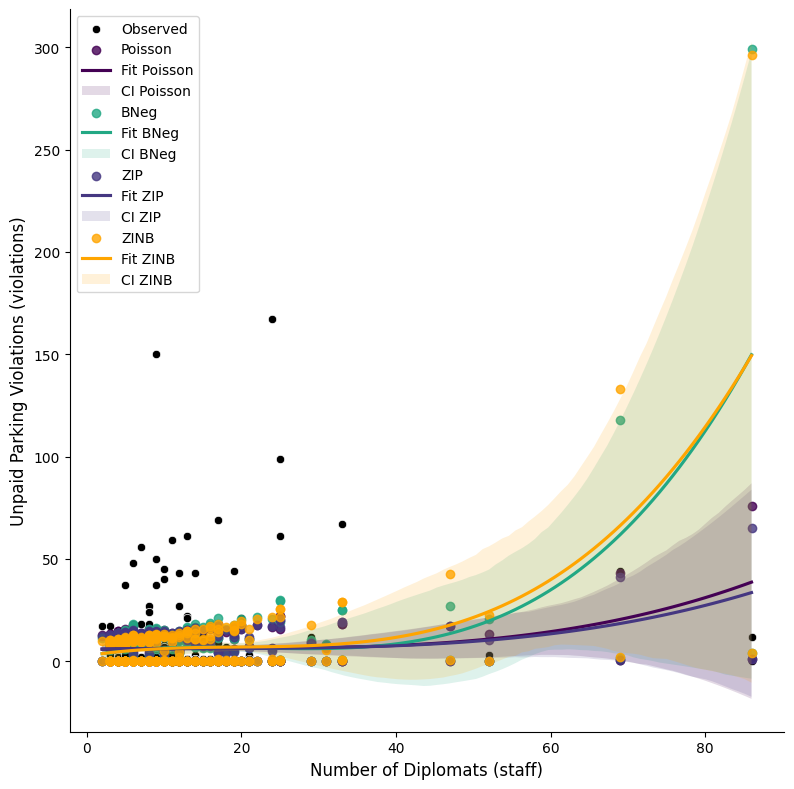

In [326]:
## Plot a Graph with the fitted values for all models (POISSON, BNEG, ZIP e ZINB)
## considering 'violations' on Y axis, in function of 'staff'on X axis, and show the CI intervalc

plt.figure(figsize=(20,10))
sns.relplot(data=df_corruption, x='staff', y='violations', color='black', height=8)
sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3,
            color='#440154FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3,
            color='#22A884FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_zip', order=3,
            color='#453781FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_zinb', order=3,
            color='orange')
plt.xlabel('Number of Diplomats (staff)', fontsize=12)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=12)
plt.legend(['Observed', 'Poisson', 'Fit Poisson', 'CI Poisson',
            'BNeg', 'Fit BNeg', 'CI BNeg',
            'ZIP', 'Fit ZIP', 'CI ZIP',
            'ZINB', 'Fit ZINB', 'CI ZINB'],
           fontsize=10)
plt.show

In [327]:
### END OF THE SCRIPT ###

## 7. Conclusion

This exercise was made for didatic purposes, so it shows in a evolutive way, how the Lok-Lik increases by
selection the proper distribution model. 

The final conclusion is that based on the distribution of the dependent variable (Y), the ZINB models offers a 
better fit and provided the Max Log-Lik. 

In [329]:
df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar,fitted_poisson,fitted_bneg,fitted_zip,fitted_zinb
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208,15.919915,16.138591,14.823562,13.358543
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289,0.216711,0.224603,0.203580,0.187939
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843,13.371720,11.987629,12.877979,10.203814
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023,0.182023,0.166834,0.176860,0.143555
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915,7.477915,5.551769,8.379367,7.494531
...,...,...,...,...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691,0.243691,0.253810,0.207250,0.183098
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347,13.486751,12.955687,13.616058,12.232444
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589,0.183589,0.180306,0.186996,0.172096
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120,12.994217,13.033499,13.732195,13.896783
